In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:2]:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/datafaces/imageszip/Images/AF219.jpg
/kaggle/input/datafaces/imageszip/Images/AM254.jpg


In [115]:
import time


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [116]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

def show_images(images):
    f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, sharey=True)
    ax1.imshow(np.array(images[0].permute(1,2,0)))#.reshape([350,350,3]),dtype=int))
    ax2.imshow(np.array(images[1].permute(1,2,0)))#.reshape([350,350,3]),dtype=int))
    ax3.imshow(np.array(images[2].permute(1,2,0)))
    ax4.imshow(np.array(images[3].permute(1,2,0)))

    plt.show()

In [117]:
#PATH_TRAIN='/kaggle/input/labelsimage/Images_preprocess/'
PATH_TRAIN='/kaggle/input/datafaces/imageszip/Images/'
batch_size = 64
ind = np.array(list(range(len(os.listdir(PATH_TRAIN)))))
np.random.shuffle(ind)
sample_train=dict(zip(list(range(int(len(ind)*0.9))),np.array(os.listdir(PATH_TRAIN))[ind[:int(len(ind)*0.9)]]))
sample_test=dict(zip(list(range(int(len(ind)*0.1))),np.array(os.listdir(PATH_TRAIN))[ind[int(len(ind)*0.9):]]))
#127.5) * 0.0078125

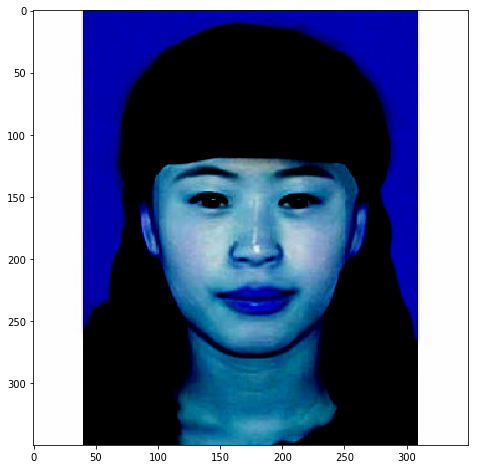

In [118]:
plt.imshow((cv2.imread(PATH_TRAIN+'AF1.jpg')-127.5)*0.0078125)

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DetectionDataset(torch.utils.data.Dataset):
    
    def __init__(self, sample):
        self.sample=sample        
    def __len__(self):
        return len(self.sample)
    
    def __getitem__(self, idx):
        img = cv2.imread(PATH_TRAIN+self.sample[idx])[:,:,::-1]
        img = DetectionDataset.preprocess_img(img)
        return img
    
    @staticmethod
    def preprocess_img(img, dsize=(64,64)):
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32)
        img=(img - 127.5) * 0.0078125
        img = np.moveaxis(img, -1, 0)
        return torch.Tensor(img)
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

In [120]:
dataset = DetectionDataset(sample=sample_train)
loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)

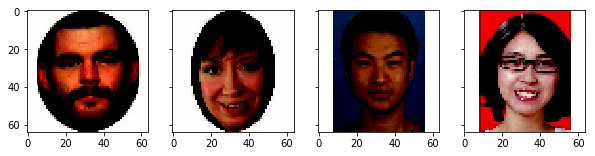

In [121]:
for x in loader_train:
    show_images(x)#[0].permute(1,2,0))
    break

In [122]:
NOISE_DIM = 100
batch_size = 64
dtype=torch.FloatTensor
datasett = DetectionDataset(sample=sample_test)
loader_val = torch.utils.data.DataLoader(datasett, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)

In [123]:
def sample_noise(batch_size, dim):
    return torch.FloatTensor(batch_size, dim).uniform_(-1, 1)

In [124]:
def get_optimizer(model):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,betas=[0.5,0.999])
    return optimizer

In [125]:
def bce_loss(input, target):
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()
def discriminator_loss(logits_real, logits_fake):
    loss = bce_loss(logits_real,torch.ones(logits_real.size()).to(device))+ bce_loss(logits_fake,torch.zeros(logits_fake.size()).to(device))
    return loss

def generator_loss(logits_fake):
    loss = bce_loss(logits_fake,torch.ones(logits_fake.size()).to(device))
    return loss

In [126]:
def ls_discriminator_loss(scores_real, scores_fake):
    loss= torch.mean(((scores_fake)**2))/2
    loss+= torch.mean(((1-scores_real)**2))/2
    return loss

def ls_generator_loss(scores_fake):
    loss = torch.mean(((scores_fake-1)**2))/2#,torch.ones(scores_fake.size()))/2
    return loss

In [139]:
class EncoderConv(nn.Module):
    def __init__(self,noise_dim=NOISE_DIM):
        super(EncoderConv, self).__init__()
        self.conv2dTransp0 = nn.ConvTranspose2d(in_channels=100,out_channels=8*64,kernel_size=4,stride=1,padding=0)
        self.batch_norm_t0=nn.BatchNorm2d(8*64)
        self.conv2dTransp1 = nn.ConvTranspose2d(in_channels=8*64,out_channels=4*64,kernel_size=4,stride=2,padding=1)
        self.batch_norm_t1=nn.BatchNorm2d(4*64)
        self.conv2dTransp2 = nn.ConvTranspose2d(in_channels=4*64,out_channels=2*64,kernel_size=4,stride=2,padding=1)
        self.batch_norm_t2=nn.BatchNorm2d(2*64)
        self.activ=nn.ReLU()
        self.conv2dTransp3 = nn.ConvTranspose2d(in_channels=2*64,out_channels=64,kernel_size=4,stride=2,padding=1)
        self.batch_norm_t3=nn.BatchNorm2d(64)
        self.conv2dTransp4 = nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=4,stride=2,padding=1)
        self.tanh = nn.Tanh()
    def forward(self,x):
        x=x.view(-1,100,1,1)
        x=self.batch_norm_t0(self.activ(self.conv2dTransp0(x)))

        x=self.batch_norm_t1(self.activ(self.conv2dTransp1(x)))
        x=self.batch_norm_t2(self.activ(self.conv2dTransp2(x)))
        x=self.batch_norm_t3(self.activ(self.conv2dTransp3(x)))
        x=self.conv2dTransp4(x)
        x=self.tanh(x)
        return x.view(-1,3,64,64)

In [140]:
EncoderConv()(torch.rand(2,100)).size()#3,128,128))

torch.Size([2, 3, 64, 64])

In [141]:
class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv,self).__init__()
        nc=3
        ndf=64
        self.extr = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )
        '''self.conv1=nn.Conv2d(3,32,3)
        self.batch_norm1=nn.BatchNorm2d(32)
        self.conv2=nn.Conv2d(32,64,3)
        self.batch_norm2=nn.BatchNorm2d(32)

        self.conv3=nn.Conv2d(64,128,3)
        self.batch_norm3=nn.BatchNorm2d(128)

        self.conv4=nn.Conv2d(128,256,3)
        self.batch_norm4=nn.BatchNorm2d(256)
        self.conv5=nn.Conv2d(256,512,3)
        self.batch_norm5=nn.BatchNorm2d(512)
        self.batch_norm6=nn.BatchNorm2d(1)

        self.pool=nn.MaxPool2d(2)
        self.conv6=nn.Conv2d(512,1,1)

        self.linear1=nn.Linear(54*54,529)
        self.batch_norm_l1=nn.BatchNorm1d(529)
        self.linear2=nn.Linear(529,1)'''
    def forward(self, x):
        '''x=self.batch_norm1(F.tanh(self.conv1(x)))
        x=(F.tanh(self.conv2(x)))
        x=(F.tanh(self.conv3(x)))
        x=(F.tanh(self.conv4(x)))
        x=(F.tanh(self.conv5(x)))
        x=self.batch_norm6(F.relu(self.conv6(x)))
        x=x.view(-1,54*54)
        x=F.relu(self.linear1(x))'''
        #x=self.dropout(F.tanh(self.linear1(x)))
        #x=self.linear2(x)
        x=self.extr(x)
        return x.view(-1,1)


In [142]:
G_DC = EncoderConv().type(dtype).to(device)
G_DC.apply(initialize_weights)
D_DC = DiscriminatorConv().type(dtype).to(device)
D_DC.apply(initialize_weights)


DiscriminatorConv(
  (extr): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [143]:
device

device(type='cuda')

In [144]:
dtype=torch.FloatTensor
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=64, noise_size=100, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0

    for epoch in range(num_epochs):
        for x in loader_train:
            D_solver.zero_grad()
            real_data = x.type(dtype).to(device)#.permute(1,2,3,0)
            logits_real = D(real_data).type(dtype).to(device)

            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype).to(device)
            #print(g_fake_seed.shape)
            fake_images = G(g_fake_seed).detach()


            logits_fake = D(fake_images)
            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()
            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype).to(device)
            fake_images = G(g_fake_seed)
            gen_logits_fake = D(fake_images)
            g_error = generator_loss(gen_logits_fake.to(device))
            g_error.backward()
            G_solver.step()
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()),'epoch',epoch)
                imgs_numpy = fake_images.data.cpu()
                #imgs_numpy=real_data.data.cpu()
                show_images(imgs_numpy)
                print()
            iter_count += 1


In [145]:
D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)


Iter: 0, D: 0.3901, G:1.68 epoch 0


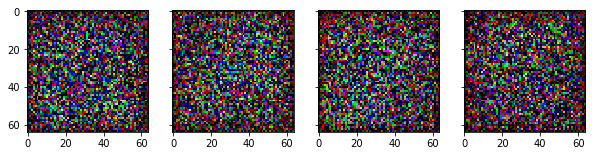


Iter: 250, D: 0.2118, G:0.2931 epoch 3


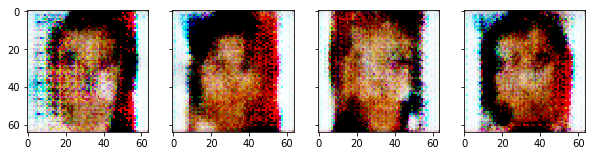


Iter: 500, D: 0.1267, G:0.5209 epoch 6


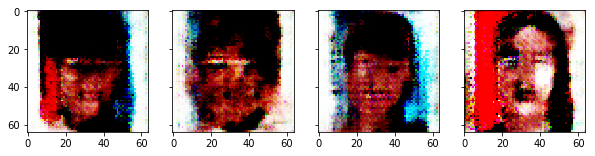


Iter: 750, D: 0.1247, G:0.3124 epoch 9


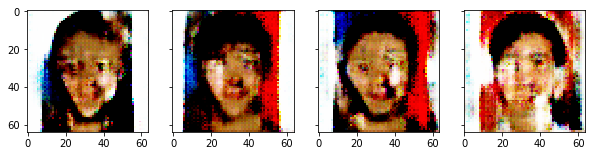


Iter: 1000, D: 0.3292, G:0.3822 epoch 12


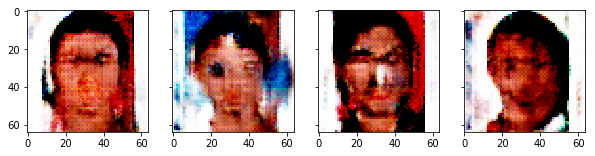


Iter: 1250, D: 0.1148, G:0.4967 epoch 16


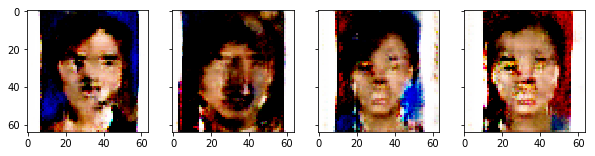


Iter: 1500, D: 0.1988, G:0.2445 epoch 19


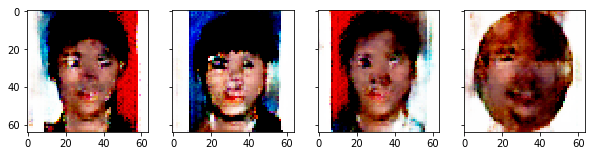


Iter: 1750, D: 0.1456, G:0.387 epoch 22


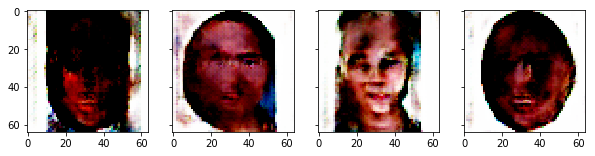


Iter: 2000, D: 0.1234, G:0.4607 epoch 25


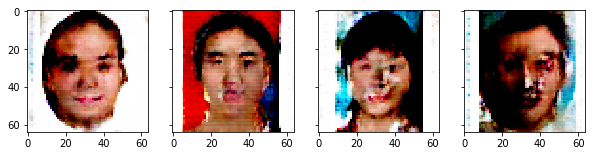


Iter: 2250, D: 0.2095, G:0.2725 epoch 29


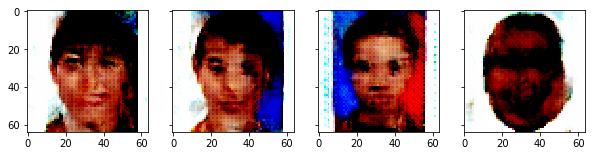


Iter: 2500, D: 0.1817, G:0.2882 epoch 32


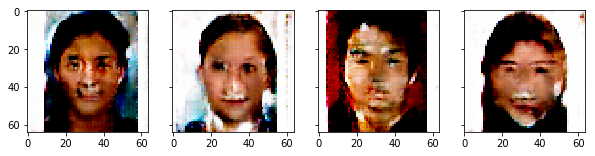


Iter: 2750, D: 0.146, G:0.3019 epoch 35


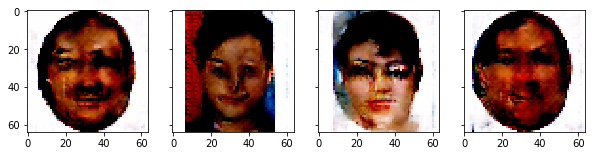


Iter: 3000, D: 0.2239, G:0.2797 epoch 38


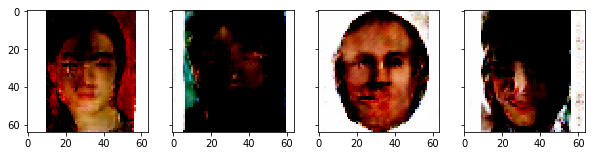


Iter: 3250, D: 0.1232, G:0.3205 epoch 42


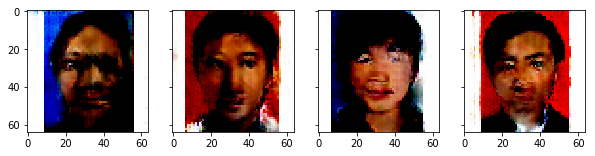


Iter: 3500, D: 0.1376, G:0.8634 epoch 45


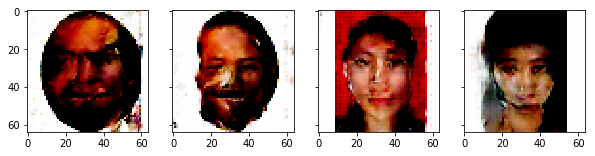


Iter: 3750, D: 0.1059, G:0.4405 epoch 48


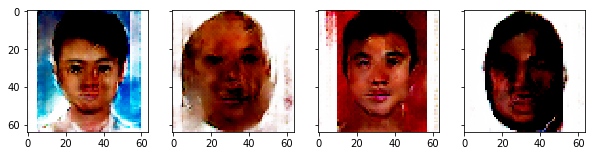


Iter: 4000, D: 0.09589, G:0.4082 epoch 51


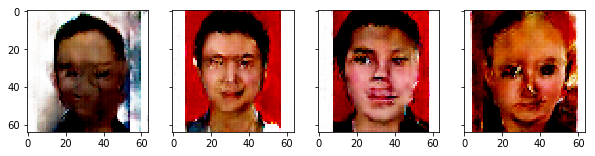


Iter: 4250, D: 0.1827, G:0.6175 epoch 55


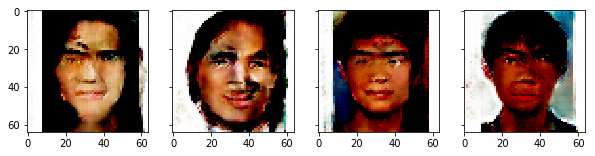


Iter: 4500, D: 0.2263, G:0.3912 epoch 58


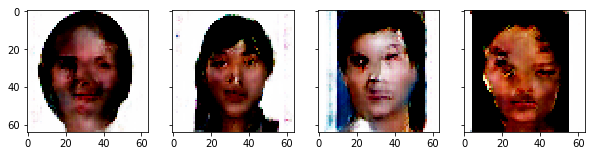


Iter: 4750, D: 0.1248, G:0.3289 epoch 61


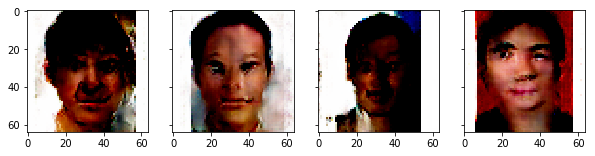


Iter: 5000, D: 0.09816, G:0.3871 epoch 64


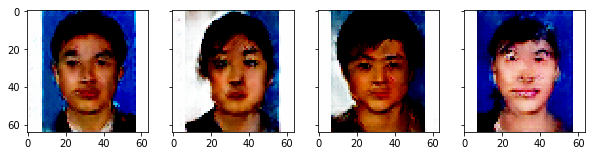


Iter: 5250, D: 0.1269, G:0.3369 epoch 68


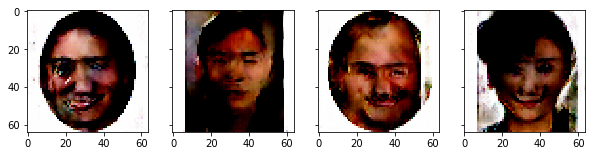


Iter: 5500, D: 0.08758, G:0.4068 epoch 71


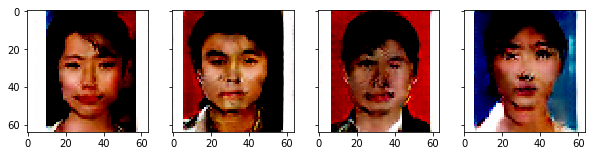


Iter: 5750, D: 0.1816, G:0.546 epoch 74


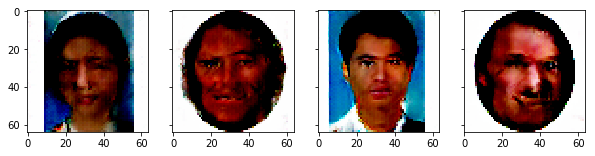


Iter: 6000, D: 0.08542, G:0.4488 epoch 77


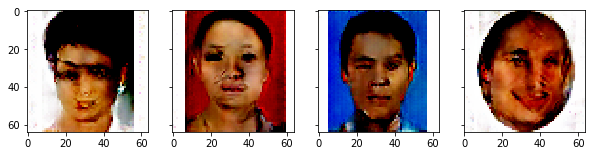


Iter: 6250, D: 0.1034, G:0.5433 epoch 81


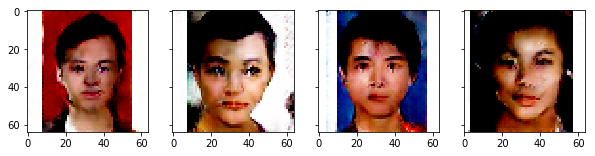


Iter: 6500, D: 0.07175, G:0.4751 epoch 84


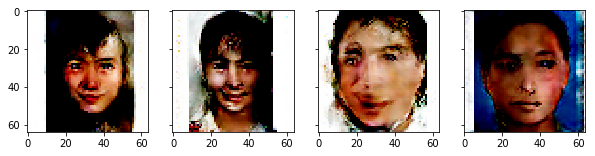


Iter: 6750, D: 0.0972, G:0.5856 epoch 87


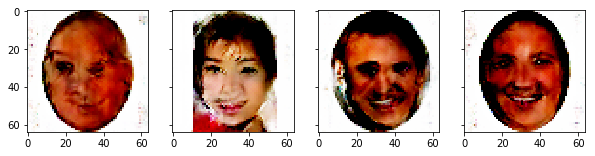


Iter: 7000, D: 0.07252, G:0.4331 epoch 90


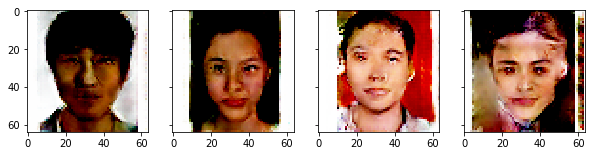


Iter: 7250, D: 0.06435, G:0.5134 epoch 94


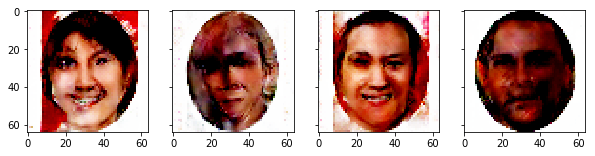


Iter: 7500, D: 0.07178, G:0.4936 epoch 97


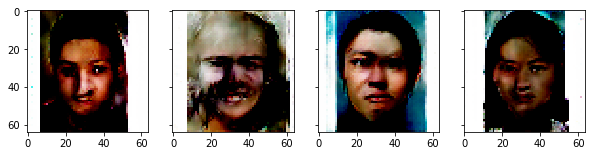


Iter: 7750, D: 0.07345, G:0.6934 epoch 100


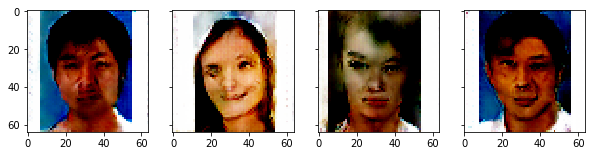


Iter: 8000, D: 0.04504, G:0.3867 epoch 103


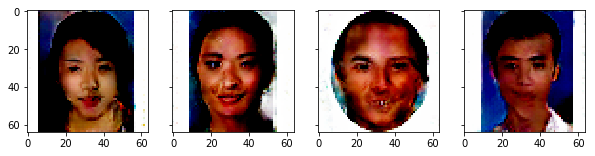


Iter: 8250, D: 0.08017, G:0.4067 epoch 107


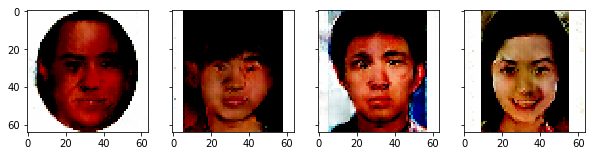


Iter: 8500, D: 0.0437, G:0.4994 epoch 110


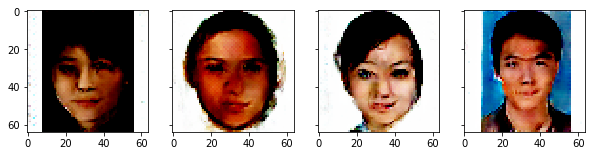


Iter: 8750, D: 7.212, G:0.5359 epoch 113


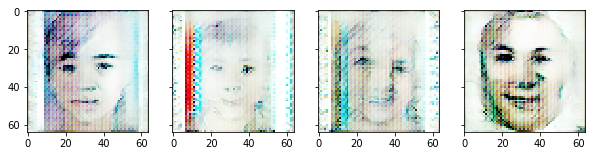


Iter: 9000, D: 0.2052, G:0.4086 epoch 116


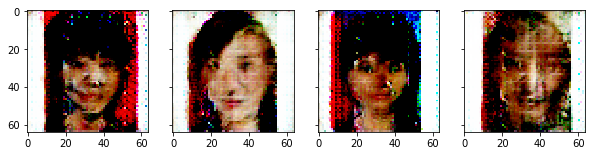


Iter: 9250, D: 0.2063, G:0.1824 epoch 120


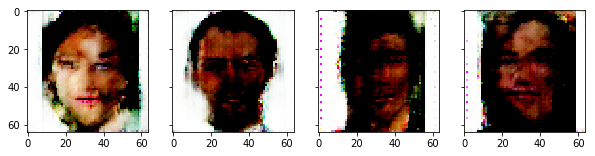


Iter: 9500, D: 0.1943, G:0.1436 epoch 123


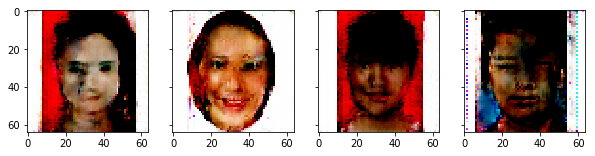


Iter: 9750, D: 0.2167, G:0.1302 epoch 126


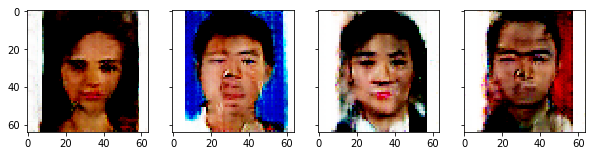


Iter: 10000, D: 0.4136, G:0.4511 epoch 129


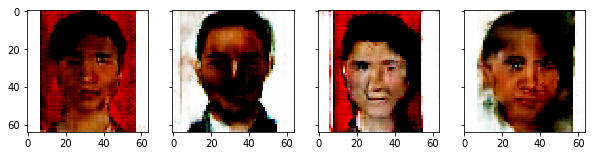


Iter: 10250, D: 0.2165, G:0.1852 epoch 133


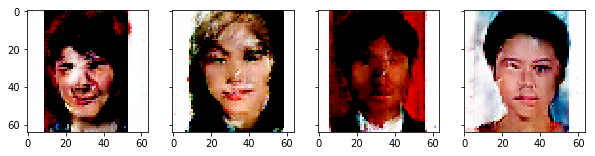


Iter: 10500, D: 0.2018, G:0.315 epoch 136


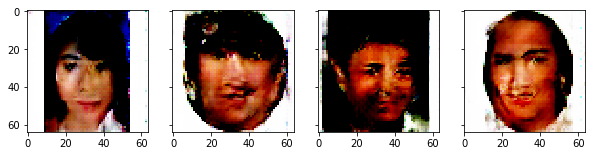


Iter: 10750, D: 0.2904, G:0.1203 epoch 139


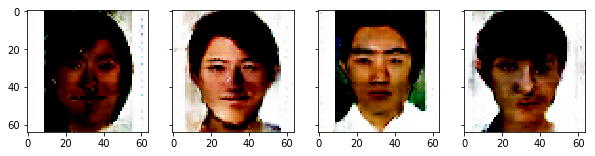


Iter: 11000, D: 0.2123, G:0.2713 epoch 142


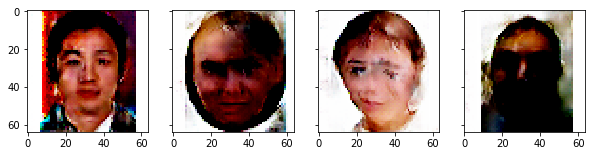


Iter: 11250, D: 0.3042, G:0.3219 epoch 146


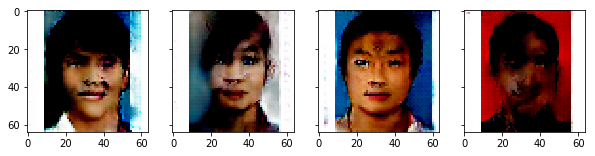


Iter: 11500, D: 0.2446, G:0.6209 epoch 149


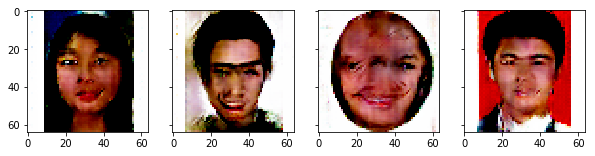


Iter: 11750, D: 0.1461, G:0.2299 epoch 152


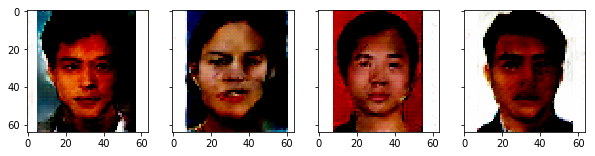


Iter: 12000, D: 0.1205, G:0.2649 epoch 155


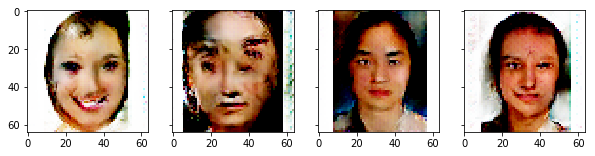


Iter: 12250, D: 0.0667, G:0.5544 epoch 159


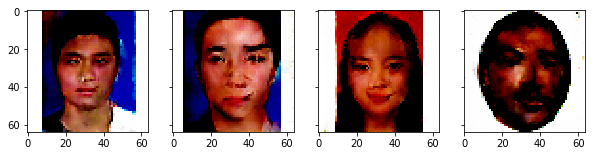


Iter: 12500, D: 0.171, G:0.7314 epoch 162


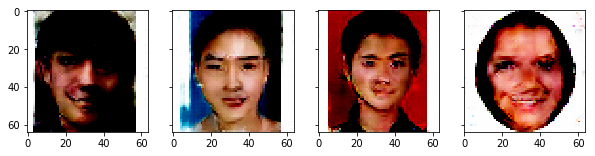


Iter: 12750, D: 0.0622, G:0.4504 epoch 165


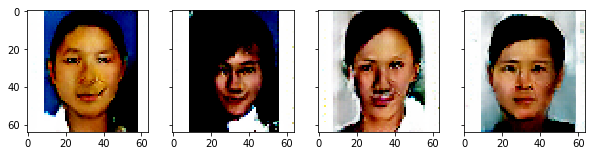


Iter: 13000, D: 0.1753, G:0.2392 epoch 168


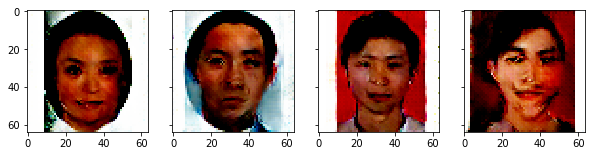


Iter: 13250, D: 0.04574, G:0.512 epoch 172


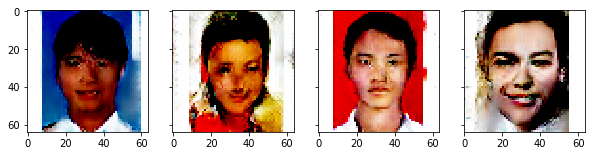


Iter: 13500, D: 0.05245, G:0.2817 epoch 175


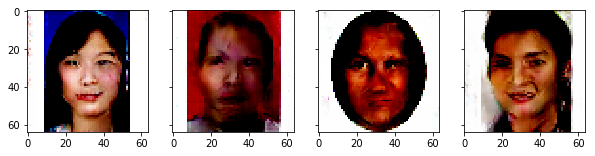


Iter: 13750, D: 0.08243, G:0.3273 epoch 178


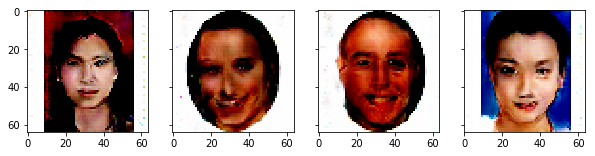


Iter: 14000, D: 0.05303, G:0.5275 epoch 181


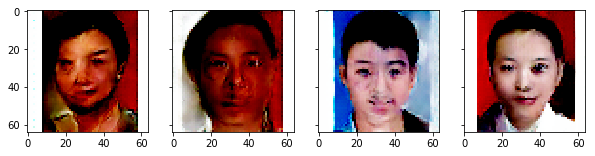


Iter: 14250, D: 0.0711, G:0.5681 epoch 185


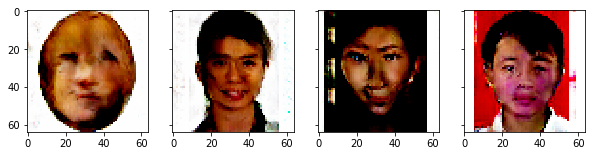


Iter: 14500, D: 0.03925, G:0.4596 epoch 188


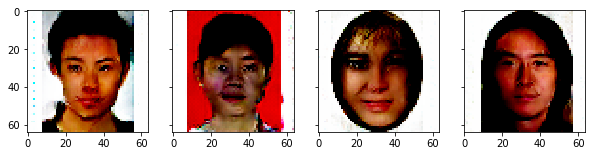


Iter: 14750, D: 0.05212, G:0.4526 epoch 191


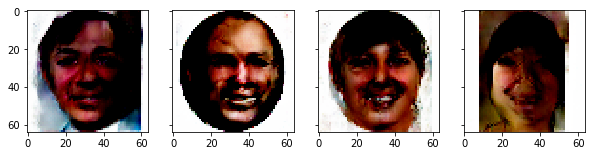


Iter: 15000, D: 0.03881, G:0.3085 epoch 194


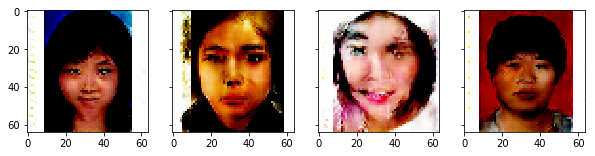


Iter: 15250, D: 0.05895, G:0.5895 epoch 198


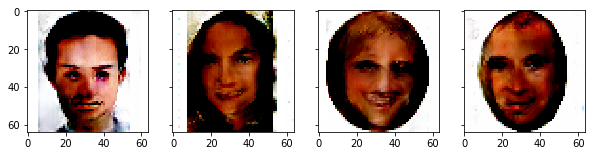


Iter: 15500, D: 0.0581, G:0.4693 epoch 201


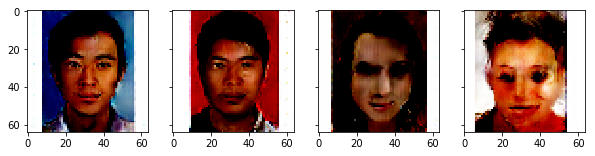


Iter: 15750, D: 0.05158, G:0.482 epoch 204


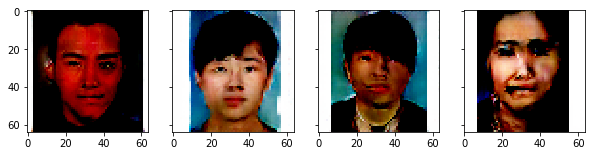


Iter: 16000, D: 0.04611, G:0.6281 epoch 207


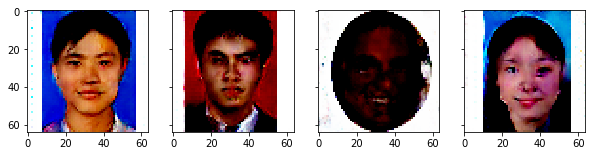


Iter: 16250, D: 0.02895, G:0.4313 epoch 211


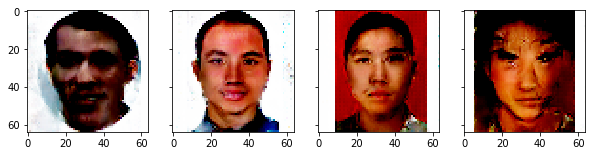


Iter: 16500, D: 0.03679, G:0.4567 epoch 214


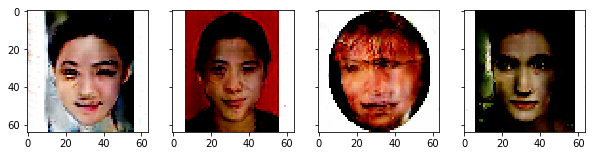


Iter: 16750, D: 0.02816, G:0.4031 epoch 217


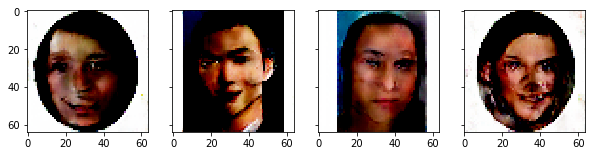


Iter: 17000, D: 0.03711, G:0.4637 epoch 220


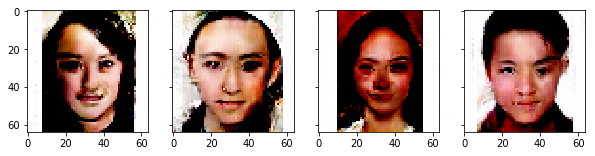


Iter: 17250, D: 0.03462, G:0.5055 epoch 224


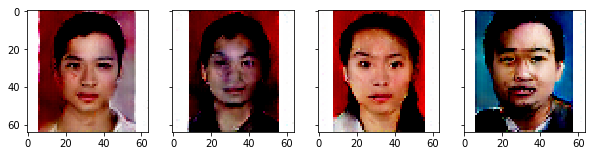


Iter: 17500, D: 0.04742, G:0.4057 epoch 227


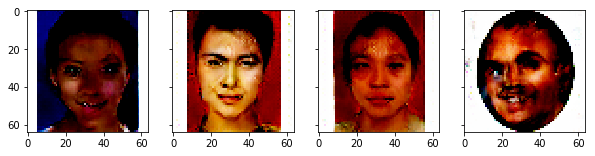


Iter: 17750, D: 0.04751, G:0.4626 epoch 230


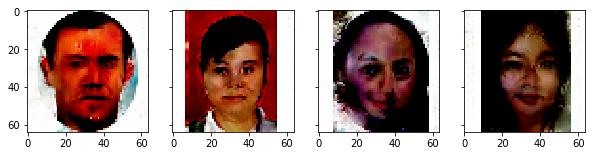


Iter: 18000, D: 0.02329, G:0.392 epoch 233


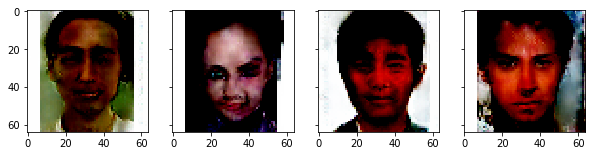


Iter: 18250, D: 0.03656, G:0.4358 epoch 237


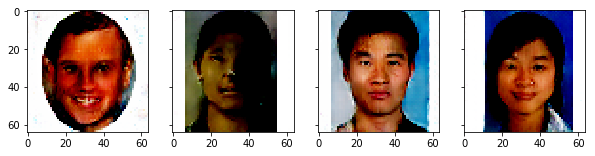


Iter: 18500, D: 0.03322, G:0.6335 epoch 240


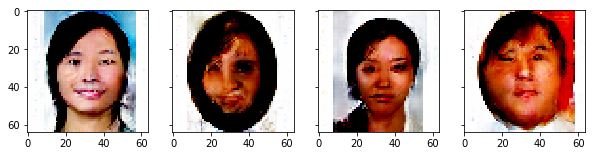


Iter: 18750, D: 0.02315, G:0.4991 epoch 243


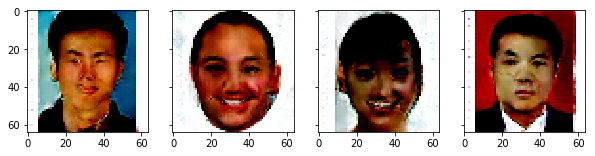


Iter: 19000, D: 0.0308, G:0.6419 epoch 246


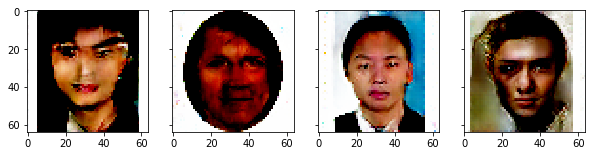


Iter: 19250, D: 0.03226, G:0.6342 epoch 250


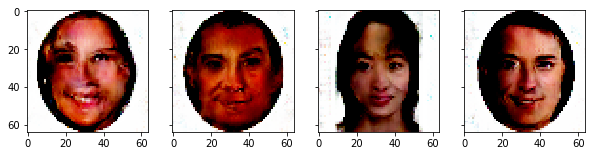


Iter: 19500, D: 0.02987, G:0.4997 epoch 253


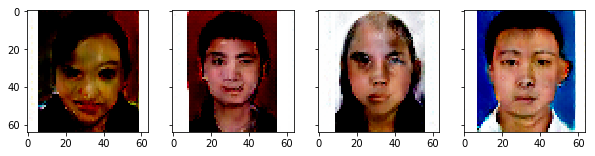


Iter: 19750, D: 0.02474, G:0.5477 epoch 256


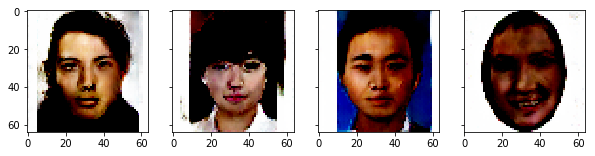


Iter: 20000, D: 0.03274, G:0.4103 epoch 259


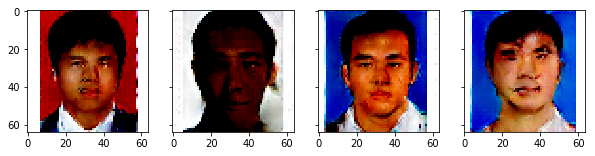


Iter: 20250, D: 0.02481, G:0.4599 epoch 262


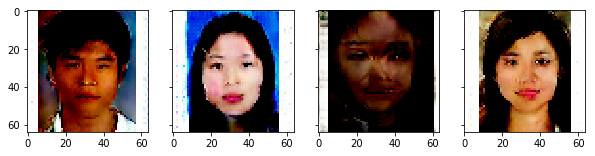


Iter: 20500, D: 0.02034, G:0.542 epoch 266


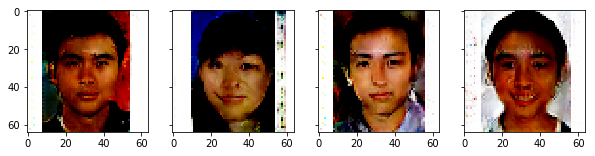


Iter: 20750, D: 0.017, G:0.5565 epoch 269


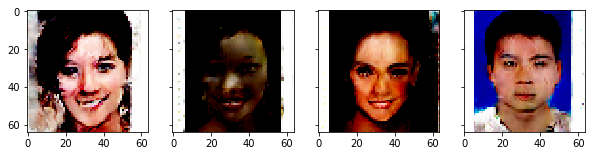


Iter: 21000, D: 0.02409, G:0.3995 epoch 272


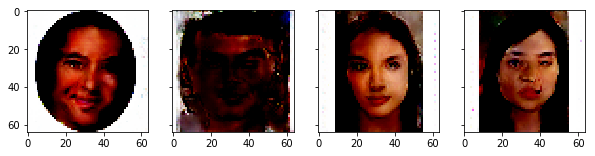


Iter: 21250, D: 0.02333, G:0.4582 epoch 275


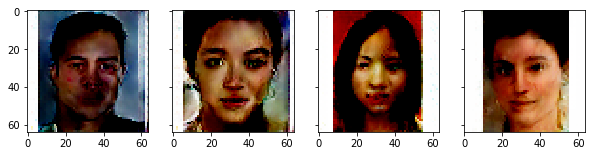


Iter: 21500, D: 0.02522, G:0.5633 epoch 279


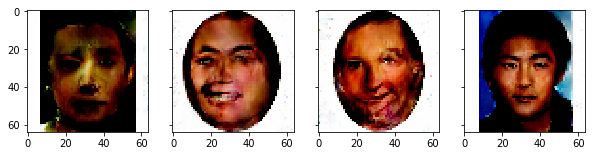


Iter: 21750, D: 0.0382, G:0.5437 epoch 282


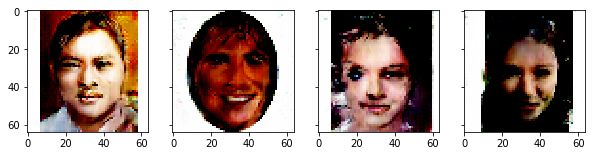


Iter: 22000, D: 0.02367, G:0.5088 epoch 285


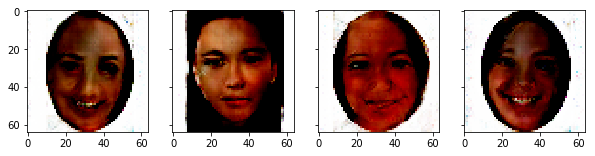


Iter: 22250, D: 0.02138, G:0.5205 epoch 288


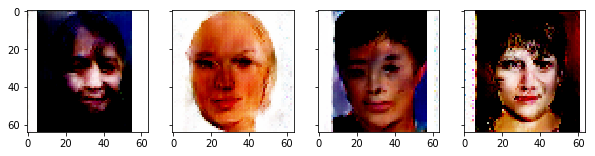


Iter: 22500, D: 0.02903, G:0.4908 epoch 292


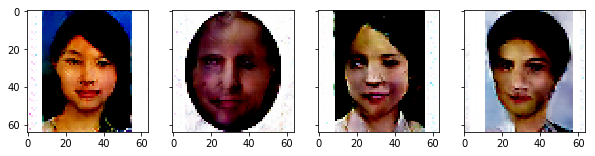


Iter: 22750, D: 0.03345, G:0.6467 epoch 295


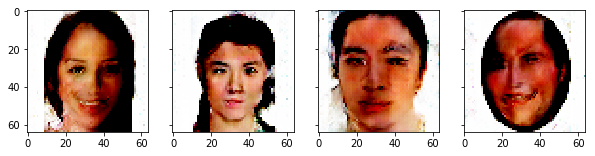


Iter: 23000, D: 0.01714, G:0.5433 epoch 298


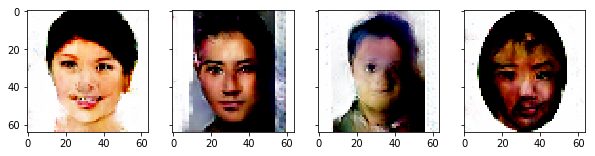


Iter: 23250, D: 0.0992, G:0.3328 epoch 301


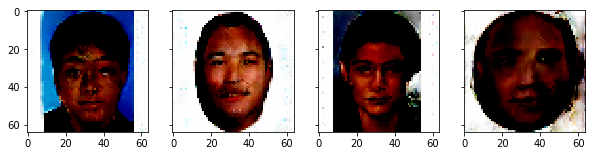


Iter: 23500, D: 0.01566, G:0.4423 epoch 305


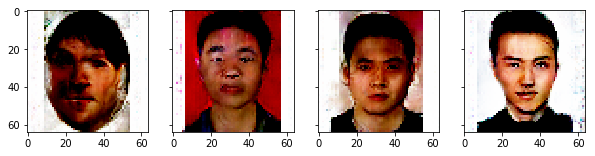


Iter: 23750, D: 0.02711, G:0.4386 epoch 308


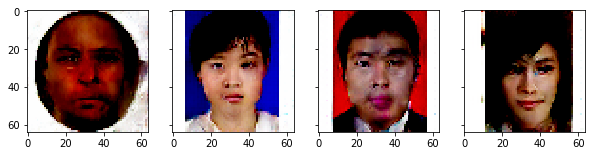


Iter: 24000, D: 0.02601, G:0.5126 epoch 311


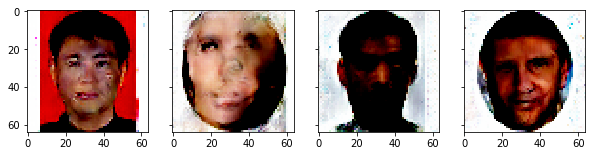


Iter: 24250, D: 0.01944, G:0.4572 epoch 314


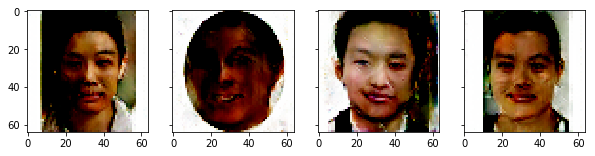


Iter: 24500, D: 0.01792, G:0.4395 epoch 318


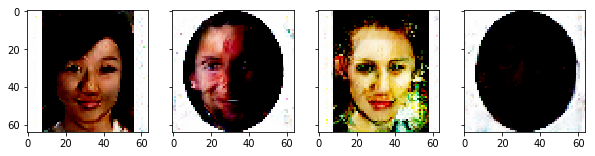


Iter: 24750, D: 0.01518, G:0.5083 epoch 321


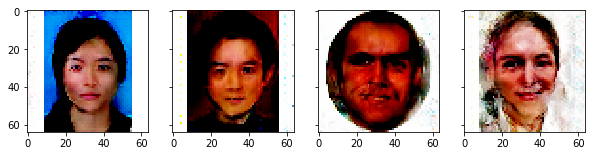


Iter: 25000, D: 0.03439, G:0.3773 epoch 324


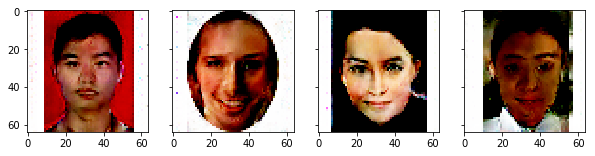


Iter: 25250, D: 0.01726, G:0.4511 epoch 327


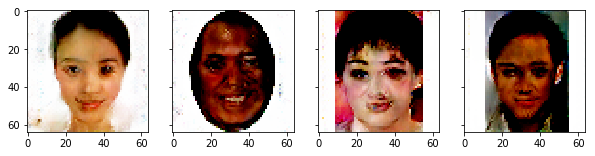


Iter: 25500, D: 0.02809, G:0.4486 epoch 331


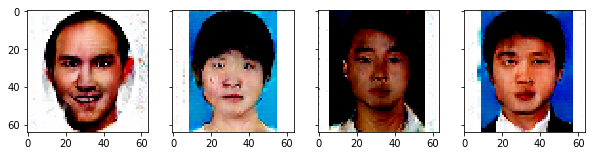


Iter: 25750, D: 0.01655, G:0.4038 epoch 334


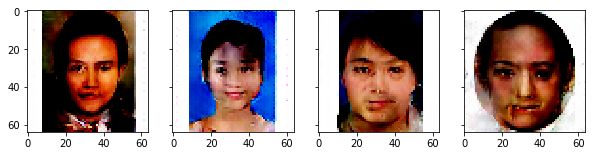


Iter: 26000, D: 0.02896, G:0.5253 epoch 337


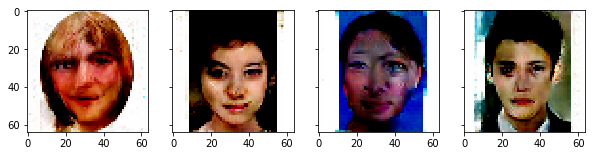


Iter: 26250, D: 0.04836, G:0.7907 epoch 340


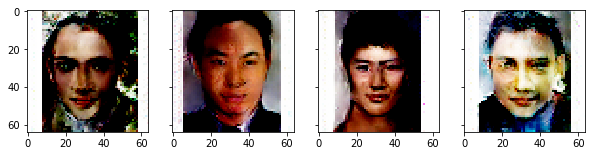


Iter: 26500, D: 0.01649, G:0.4919 epoch 344


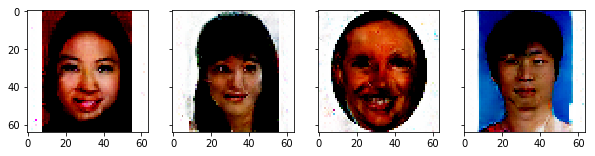


Iter: 26750, D: 0.02957, G:0.4032 epoch 347


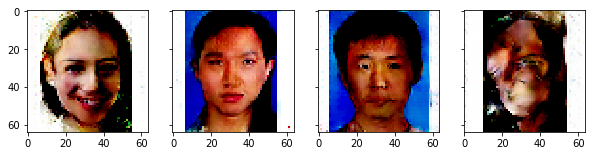


Iter: 27000, D: 0.02213, G:0.5215 epoch 350


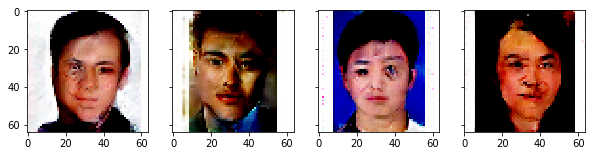


Iter: 27250, D: 0.01844, G:0.5277 epoch 353


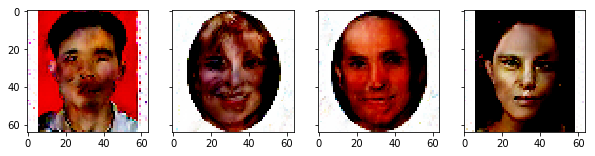


Iter: 27500, D: 0.01649, G:0.5035 epoch 357


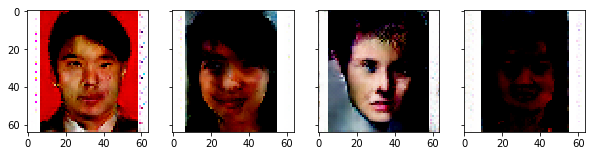


Iter: 27750, D: 0.02316, G:0.6061 epoch 360


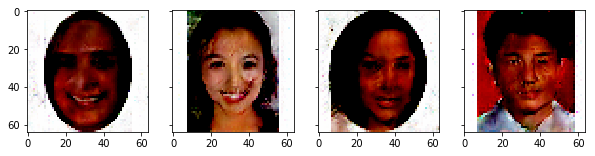

KeyboardInterrupt: 

In [146]:
run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, ls_discriminator_loss, ls_generator_loss, num_epochs=500)

In [148]:
torch.save(G_DC.state_dict(), 'generator')


In [149]:
from IPython.display import FileLink, FileLinks
FileLink('generator')

/kaggle/working/generator

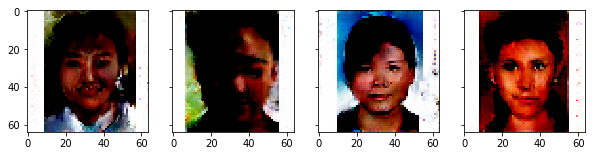

In [169]:
show_images(G_DC(sample_noise(4,100).to(device)).detach().cpu())